# 获取并可视化股市数据

## 从雅虎金融获取数据

在分析数据之前得先得到数据。股市数据可以从[Yahoo! Finance](http://finance.yahoo.com/)、 [Google Finance](http://finance.google.com/)以及其他的地方拿到。同时，pandas包提供了轻松从以上网站获取数据的方法。这节课我们使用雅虎金融的数据。

下面的代码展示了如何直接创建一个含有股市数据的DataFrame。（更多关于远程获取数据的信息，点击[这里](http://pandas.pydata.org/pandas-docs/stable/remote_data.html)）

In [1]:
import pandas as pd
import pandas_datareader as pdr
import datetime

# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
apple = pdr.get_data_yahoo("AAPL", start, end)

type(apple)

pandas.core.frame.DataFrame

In [2]:
apple.head()

,date,high,low,open,close,volume,adjclose
0,2018-03-20,176.789993,175.199997,175.240005,175.639999,8961655.0,175.639999
1,2018-03-19,177.470001,173.660004,177.320007,175.300003,32855800.0,175.300003
2,2018-03-16,179.119995,177.619995,178.649994,178.020004,39404700.0,178.020004
3,2018-03-15,180.240005,178.070007,178.500000,178.649994,22743800.0,178.649994
4,2018-03-14,180.520004,177.809998,180.320007,178.440002,29368400.0,178.440002


让我们简单说一下数据内容。**open**是当天的开始价格（不是前一天闭市的价格）；**high**是股票当天的最高价；**low**是股票当天的最低价；**close**是闭市时间的股票价格。**volume**指交易数量。**adjustclose**是根据法人行为调整之后的闭市价格。虽然股票价格基本上是由交易者决定的，stock splits （拆股。指上市公司将现有股票一拆为二，新股价格为原股的一半的行为）以及dividends（分红。每一股的分红）同样也会影响股票价格，也应该在模型中被考虑到。

## 可视化股市数据

获得数据之后让我们考虑将其可视化。下面我会演示如何使用**matplotlib**包。值得注意的是apple DataFrame对象有一个plot()方法让画图变得更简单。

In [3]:
import matplotlib.pyplot as plt   # Import matplotlib
import pylab

pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

apple["adjclose"].plot(grid = True) # Plot the adjusted closing price of AAPL

线段图是可行的，但是每一天的数据至少有四个变量（开市，股票最高价，股票最低价和闭市），我们希望找到一种不需要我们画四条不同的线就能看到这四个变量走势的可视化方法。一般来说我们使用烛柱图（也称为日本阴阳烛图表）来可视化金融数据，烛柱图最早在18世纪被日本的稻米商人所使用。可以用matplotlib来作图，但是需要费些功夫。

你们可以使用我实现的一个函数更容易地画烛柱图，它接受pandas的DataFrame作为数据来源。（程序基于[这个例子](http://matplotlib.org/examples/pylab_examples/finance_demo.html), 你可以从[这里](http://matplotlib.org/api/finance_api.html)找到相关函数的文档。）

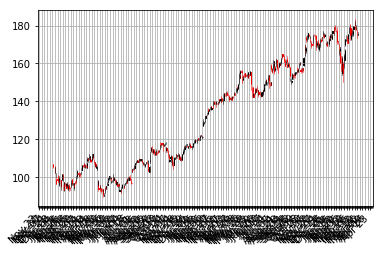

In [4]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["open", "high", "low", "close"]]
    transdat.index = dat['date']
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(mdates.date2num(plotdat.index.tolist())), plotdat["open"].tolist(), plotdat["high"].tolist(),
                      plotdat["low"].tolist(), plotdat["close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple)

烛状图中黑色线条代表该交易日闭市价格高于开市价格（盈利），红色线条代表该交易日开市价格高于闭市价格（亏损）。刻度线代表当天交易的最高价和最低价（影线用来指明烛身的哪端是开市，哪端是闭市）。烛状图在金融和技术分析中被广泛使用在交易决策上，利用烛身的形状，颜色和位置。我今天不会涉及到策略。

我们也许想要把不同的金融商品呈现在一张图上：这样我们可以比较不同的股票，比较股票跟市场的关系，或者可以看其他证券，例如交易所交易基金(ETFs)。在后面的内容中，我们将会学到如何画金融证券跟一些指数（移动平均）的关系。届时你需要使用线段图而不是烛状图。（试想你如何重叠不同的烛状图而让图表保持整洁？）

下面我展示了不同技术公司股票的数据，以及如何调整数据让数据线聚在一起。

In [5]:
microsoft = pdr.get_data_yahoo("MSFT", start, end)
google = pdr.get_data_yahoo("GOOG", start, end)
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["adjclose"],
                      "MSFT": microsoft["adjclose"],
                      "GOOG": google["adjclose"]})
 
stocks.head()

,AAPL,GOOG,MSFT
0,175.639999,1091.979980,93.230003
1,175.300003,1099.819946,92.889999
2,178.020004,1135.729980,94.599998
3,178.649994,1149.579956,94.180000
4,178.440002,1149.489990,93.849998


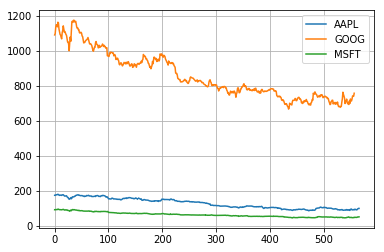

In [6]:
stocks.plot(grid = True)

这张图表的问题在哪里呢？虽然价格的绝对值很重要（昂贵的股票很难购得，这不仅会影响它们的波动性，也会影响你交易它们的难易度），但是在交易中，我们更关注每支股票价格的变化而不是它的价格。Google的股票价格比苹果微软的都高，这个差别让苹果和微软的股票显得波动性很低，而事实并不是那样。

一个解决办法就是用两个不同的标度来作图。一个标度用于苹果和微软的数据；另一个标度用来表示Google的数据。

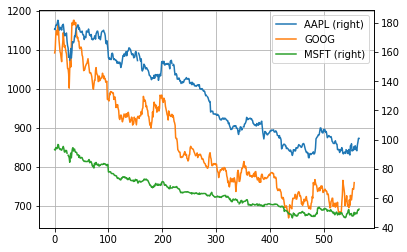

In [7]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

一个“更好”的解决方法是可视化我们实际关心的信息：股票的收益。这需要我们进行必要的数据转化。数据转化的方法很多。其中一个转化方法是将每个交易日的股票价格跟比较我们所关心的时间段开始的股票价格相比较。也就是：

text{return}_{t,0} = frac{text{price}_t}{text{price}_0} 

这需要转化stock对象中的数据，操作如下：

In [8]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

,AAPL,GOOG,MSFT
0,1.000000,1.000000,1.000000
1,0.998064,1.007180,0.996353
2,1.013550,1.040065,1.014695
3,1.017137,1.052748,1.010190
4,1.015942,1.052666,1.006650


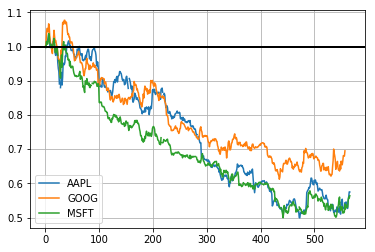

In [9]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

这个图就有用多了。现在我们可以看到从我们所关心的日期算起，每支股票的收益有多高。而且我们可以看到这些股票之间的相关性很高。它们基本上朝同一个方向移动，在其他类型的图表中很难观察到这一现象。

我们还可以用每天的股值变化作图。一个可行的方法是我们使用后一天$t + 1$和当天$t$的股值变化占当天股价的比例：

text{growth}_t = frac{text{price}_{t + 1} - text{price}_t}{text{price}_t} 

我们也可以比较当天跟前一天的价格：

text{increase}_t = frac{text{price}_{t} - text{price}_{t-1}}{text{price}_t} 

以上的公式并不相同，可能会让我们得到不同的结论，但是我们可以使用对数差异来表示股票价格变化：

text{change}_t = log(text{price}_{t}) - log(text{price}_{t - 1}) 

(这里的log 是自然对数,我们的定义不完全取决于使用 log(text{price}_{t}) - log(text{price}_{t - 1}) 还是 log(text{price}_{t+1}) - log(text{price}_{t}).) 使用对数差异的好处是该差异值可以被解释为股票的百分比差异，但是不受分母的影响。

下面的代码演示了如何计算和可视化股票的对数差异：

In [10]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,AAPL,GOOG,MSFT
0,NaN,NaN,NaN
1,-0.001938,0.007154,-0.003654
2,0.015397,0.032129,0.018241
3,0.003533,0.012121,-0.004450
4,-0.001176,-0.000078,-0.003510


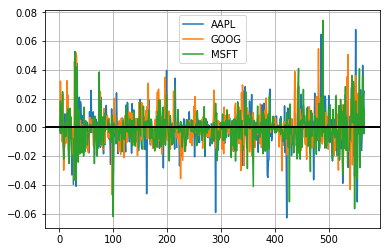

In [11]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

你更倾向于哪种转换方法呢？从相对时间段开始日的收益差距可以明显看出不同证券的总体走势。不同交易日之间的差距被用于更多预测股市行情的方法中，它们是不容被忽视的。

# 移动平均值

图表非常有用。在现实生活中，有些交易人在做决策的时候几乎完全基于图表（这些人是“技术人员”，从图表中找到规律并制定交易策略被称作**技术分析**，它是交易的基本教义之一。）下面让我们来看看如何找到股票价格的变化趋势。

一个q天的移动平均值（用MA^q_t来表示）定义为：对于某一个时间点t，它之前q天的平均值。

MA^q_t = frac{1}{q} sum_{i = 0}^{q-1} x_{t - i} 

移动平均值可以让一个系列的数据变得更平滑，有助于我们找到趋势。q值越大，移动平均对短期的波动越不敏感。移动平均的基本目的就是从噪音中识别趋势。快速的移动平均有偏小的q，它们更接近股票价格；而慢速的移动平均有较大的q值，这使得它们对波动不敏感从而更加稳定。

pandas提供了计算移动平均的函数。下面我将演示使用这个函数来计算苹果公司股票价格的20天（一个月）移动平均值，并将它跟股票价格画在一起。

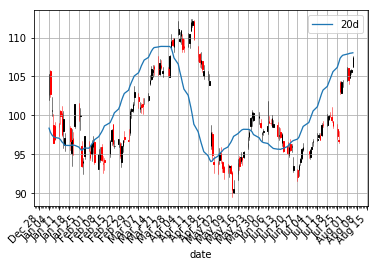

In [12]:
apple["20d"] = np.round(apple["close"].rolling(window = 20, center = False).mean(), 2)
apple.index = apple['date']

import datetime as dt
pandas_candlestick_ohlc(apple.loc[dt.date(2016,8,7):dt.date(2016,1,4),:], otherseries = "20d")

注意到平均值的起始点时间是很迟的。我们必须等到20天之后才能开始计算该值。这个问题对于更长时间段的移动平均来说是个更加严重的问题。因为我希望我可以计算200天的移动平均，我将扩展我们所得到的苹果公司股票的数据，但我们主要还是只关注2016。

In [13]:
start = datetime.datetime(2010,1,1)
apple = pdr.get_data_yahoo("AAPL", start, end)
apple.index = apple['date']

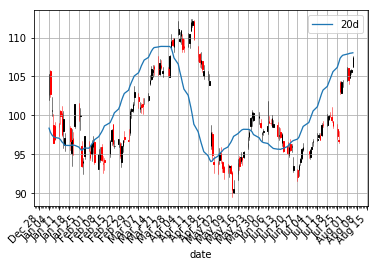

In [14]:
apple["20d"] = np.round(apple["close"].rolling(window = 20, center = False).mean(), 2)

import datetime as dt
pandas_candlestick_ohlc(apple.loc[dt.date(2016,8,7):dt.date(2016,1,4),:], otherseries = "20d")

你会发现移动平均比真实的股票价格数据平滑很多。而且这个指数是非常难改变的：一支股票的价格需要变到平局值之上或之下才能改变移动平均线的方向。因此平均线的交叉点代表了潜在的趋势变化，需要加以注意。

交易者往往对不同的移动平均感兴趣，例如20天，50天和200天。要同时生成多条移动平均线也不难：

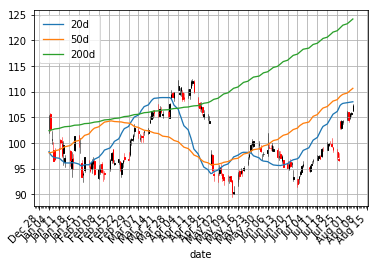

In [15]:
apple["50d"] = np.round(apple["close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["close"].rolling(window = 200, center = False).mean(), 2)

import datetime as dt
pandas_candlestick_ohlc(apple.loc[dt.date(2016,8,7):dt.date(2016,1,4),:], otherseries = ["20d", "50d", "200d"])

20天的移动平均线对小的变化非常敏感，而200天的移动平均线波动最小。这里的200天平均线显示出来总体的熊市趋势：股值总体来说一直在下降。20天移动平均线所代表的信息是熊市牛市交替，接下来有可能是牛市。这些平均线的交叉点就是交易信息点，它们代表股票价格的趋势会有所改变因而你需要作出能盈利的相应决策。

请移动下节内容。你将读到如何使用移动平局线来设计和测试交易策略。

更新：该文章早期版本提到算法交易跟高频交易是一个意思。但是网友评论指出这并不一定：算法可以用来进行交易但不一定就是高频。高频交易是算法交易中间很大的一部分，但是两者不等价。